Data: "MGE-derived interneurons integrated with 10X sequencing MOp data"

https://cellxgene.cziscience.com/collections/20a1dadf-a3a7-4783-b311-fcff3c457763



In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8" #the number of physical cores you have

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap


# Load the .h5ad file
adata = sc.read_h5ad("c2c0a633-136f-4c97-ab51-062ce97ad802.h5ad")
# Convert to DataFrame (genes as columns, cells as rows)
df = adata.to_df()

# Optionally, add metadata to the DataFrame
df.index = adata.obs.index  # Cell IDs
df.columns = adata.var.index  # Gene names

# Print the first few rows
#print(df.head())

df_metadata = adata.obs.copy()  # Cell metadata
df_gene_info = adata.var.copy()  # Gene metadata

# Show a summary
#print(df_metadata.head())
#print(df_gene_info.head())

In [3]:
# Check the column names in metadata to find the relevant one
print(df_metadata.columns)
print(df_metadata["assay"].value_counts())


Index(['Number', 'Slice', 'Date', 'Sample', 'Mouse date of birth', 'Mouse age',
       'Mouse genotype', 'Targeted layer', 'Inferred layer', 'Cre',
       'Exon reads', 'Intron reads', 'Intergenic reads', 'Sequencing batch',
       'Number of genes detected', 'RNA family', 'BICCN_cluster_label',
       'RNA type confidence', 'RNA type top-3', 'ALMVISp top-3', 'Length (bp)',
       'Yield (pgµl)', 'User', 'Hold Time (min)', 'Soma depth (µm)',
       'Soma depth (4x)', 'Cortical thickness (4x)', 'Cortical thickness (µm)',
       'Traced', 'Exclusion reasons', 'BICCN_ontology_term_id',
       'BICCN_subclass_label', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'donor_id',
       'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease',


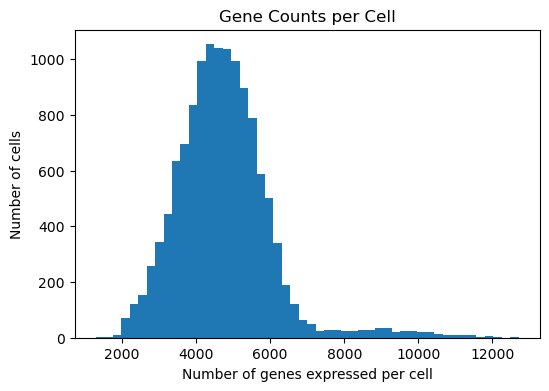

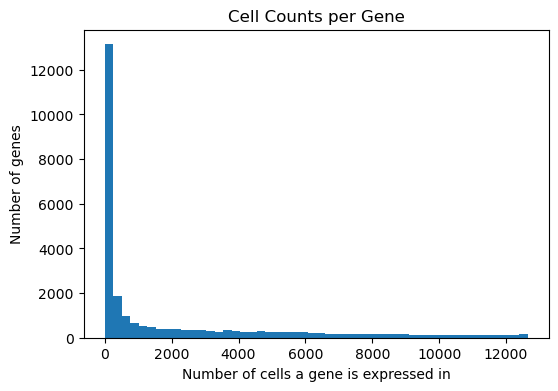

In [4]:
## Check the Distribution of Gene & Cell Counts

# Calculate number of expressed genes per cell
genes_per_cell = (df > 0).sum(axis=1)

# Calculate number of cells per gene
cells_per_gene = (df > 0).sum(axis=0)

# Plot distribution of genes per cell
plt.figure(figsize=(6, 4))
plt.hist(genes_per_cell, bins=50)
plt.xlabel("Number of genes expressed per cell")
plt.ylabel("Number of cells")
plt.title("Gene Counts per Cell")
plt.show()

# Plot distribution of cells per gene
plt.figure(figsize=(6, 4))
plt.hist(cells_per_gene, bins=50)
plt.xlabel("Number of cells a gene is expressed in")
plt.ylabel("Number of genes")
plt.title("Cell Counts per Gene")
plt.show()

In [5]:
# Normalize each cell to have 10,000 total counts
df_normalized = df.div(df.sum(axis=1), axis=0) * 1e4

# Log1p transformation (log(x + 1))
df_log = np.log1p(df_normalized)

# Show first rows
df_log.head()

,ENSMUSG00000026791,ENSMUSG00000029802,ENSMUSG00000107325,ENSMUSG00000057551,ENSMUSG00000056605,ENSMUSG00000035780,ENSMUSG00000045725,ENSMUSG00000027312,ENSMUSG00000030806,ENSMUSG00000060206,...,ENSMUSG00000038900,ENSMUSG00000032641,ENSMUSG00000085375,ENSMUSG00000110709,ENSMUSG00000073953,ENSMUSG00000115784,ENSMUSG00000075161,ENSMUSG00000034226,ENSMUSG00000059975,ENSMUSG00000043605
20180213_sample_5-0,0.215454,0.375378,0.0,0.600212,0.0,0.0,0.0,1.232430,0.766168,0.760270,...,0.255448,0.828857,0.0,0.0,0.0,0.0,0.0,0.434453,0.0,0.0
20180215_sample_1-0,0.000000,0.000000,0.0,0.957568,0.0,0.0,0.0,0.285120,1.302807,0.518771,...,0.404736,0.031680,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180220_sample_1-0,0.236346,0.000000,0.0,0.483719,0.0,0.0,0.0,1.113181,0.304158,0.188440,...,0.000000,0.571100,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180225_sample_7-0,0.836066,0.004348,0.0,0.761593,0.0,0.0,0.0,0.495040,1.299329,0.134356,...,0.232265,0.636018,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20180306_sample_1-0,0.000000,0.000000,0.0,0.662795,0.0,0.0,0.0,0.594921,0.178879,1.033845,...,0.302012,0.330564,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Explained variance by first 10 PCs: [0.05431883 0.02380748 0.0132913  0.01138443 0.01101794 0.01014169
 0.00802401 0.00595887 0.00521249 0.00394678]


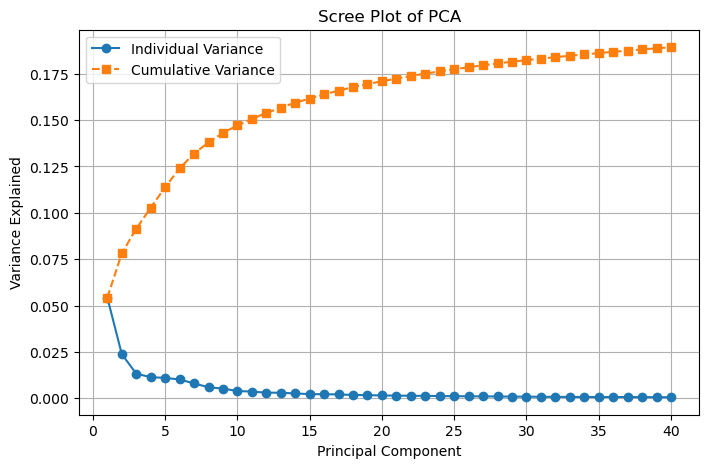

In [6]:
# Run PCA
pca = PCA(n_components=40)
pca_result = pca.fit_transform(df_log)

# Convert PCA result to a DataFrame
df_pca = pd.DataFrame(pca_result, index=df_log.index)

# Check variance explained by top PCs
explained_variance = pca.explained_variance_ratio_
print("Explained variance by first 10 PCs:", explained_variance[:10])

# Compute cumulative variance
cumulative_variance = np.cumsum(explained_variance[:50])

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 41), explained_variance[:40], marker="o", linestyle="-", label="Individual Variance")
plt.plot(range(1, 41), cumulative_variance[:40], marker="s", linestyle="--", label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot of PCA")
plt.legend()
plt.grid()
plt.show()

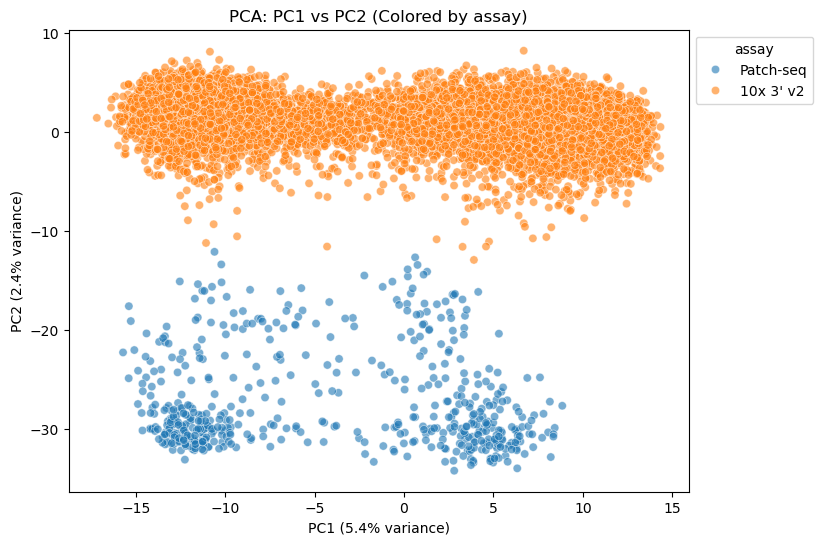

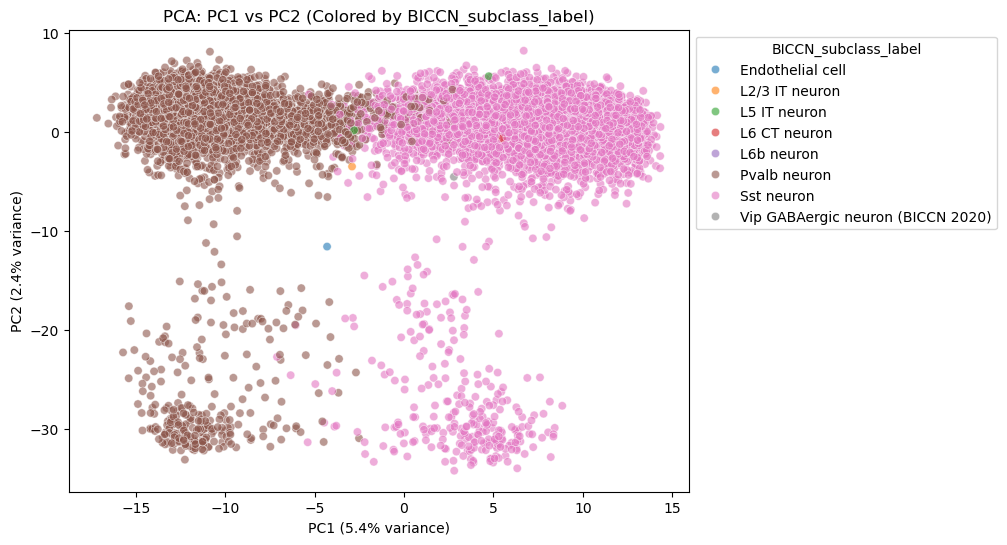

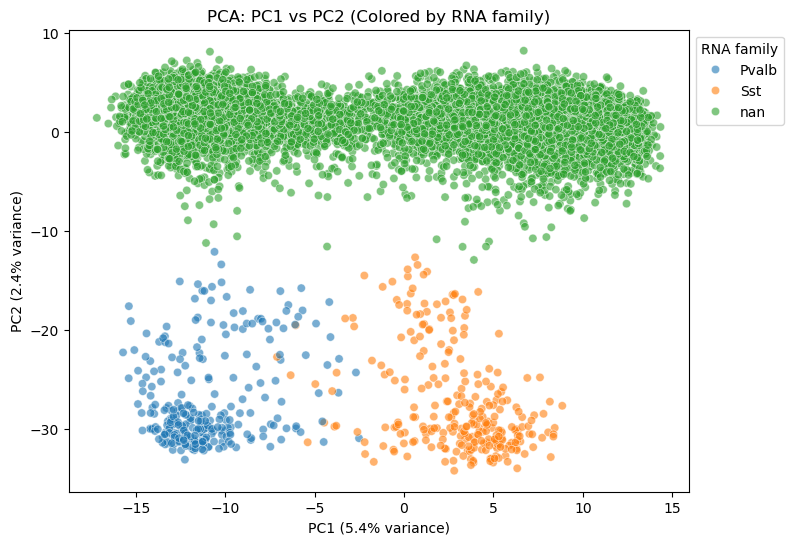

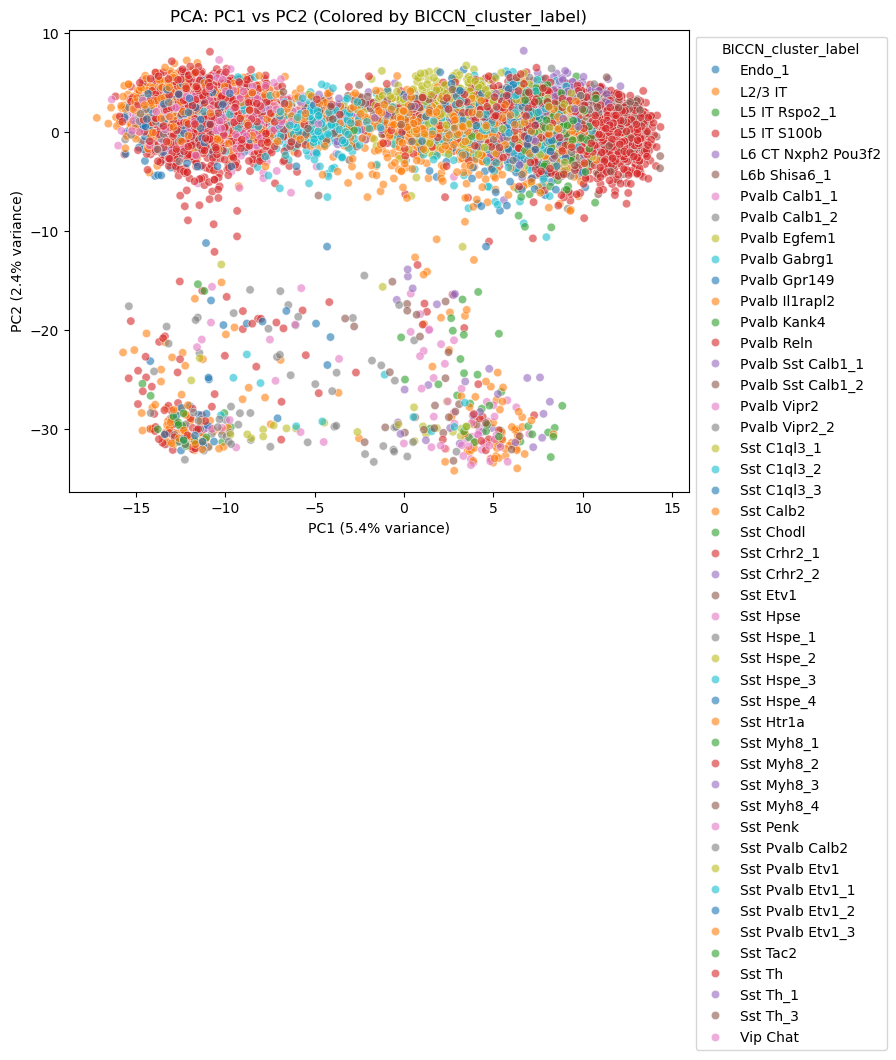

In [7]:
features_to_plot = ['assay', 'BICCN_subclass_label','RNA family', 'BICCN_cluster_label']

for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=adata.obs.loc[df_pca.index, feature], 
                    palette="tab10", alpha=0.6)
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
    plt.title(f"PCA: PC1 vs PC2 (Colored by {feature})")
    plt.legend(title=feature, bbox_to_anchor=(1, 1))
    plt.show()

#TODO make these plots nice for the report - 4 subplots, a-d

# # Create a 2x2 grid of subplots
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes = axes.flatten()  # Flatten the axes array to easily loop through it

# # Loop through each feature and create a subplot for each
# for i, feature in enumerate(features_to_plot):
#     ax = axes[i]  # Select the subplot axis
#     sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=adata.obs.loc[df_pca.index, feature], 
#                     palette="tab10", alpha=0.6, ax=ax)
#     ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
#     ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
#     ax.set_title(f"PCA: PC1 vs PC2 (Colored by {feature})")
    
#     # Adjust legend position and size
#     ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12, 
#               ncol=2, columnspacing=1)

# # Adjust layout to avoid overlap
# #plt.tight_layout()

# # Show the plots
# plt.show()


Logistic Regression Accuracy: 1.00


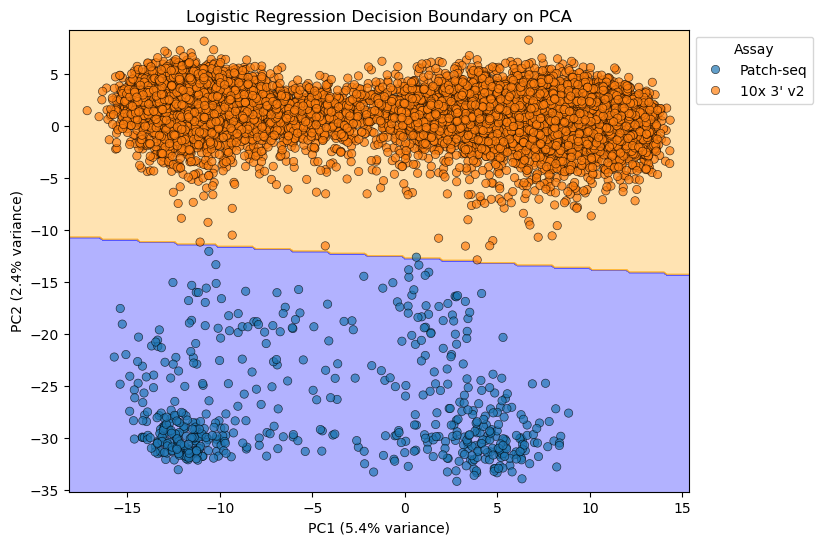

In [8]:
# Extract PC1 and PC2
df_pca['PC1'] = df_pca[0]
df_pca['PC2'] = df_pca[1]

# Ensure 'assay' is categorical
df_pca['assay'] = adata.obs.loc[df_pca.index, 'assay']

# Convert 'assay' into numerical labels (binary classification)
# If 'assay' has more than two categories, you may need to adjust this
df_pca['assay_label'] = df_pca['assay'].astype('category').cat.codes

# Extract features and target
X = df_pca[['PC1', 'PC2']].values
y = df_pca['assay_label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict probability for each point in meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'orange']))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['assay'], edgecolor='k', alpha=0.7, palette="tab10")
plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
plt.title("Logistic Regression Decision Boundary on PCA")
plt.legend(title="Assay", bbox_to_anchor=(1, 1))
plt.show()


Logistic Regression Accuracy: 0.99


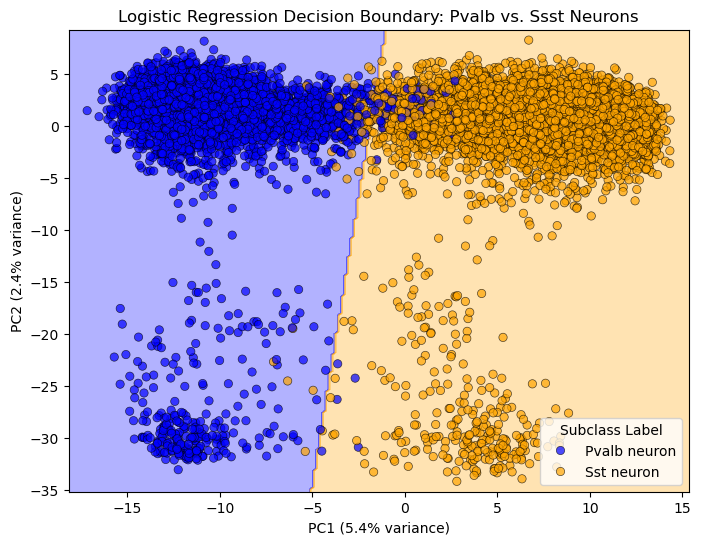

In [13]:
df_pca['BICCN_subclass_label'] = adata.obs.loc[df_pca.index, 'BICCN_subclass_label']

# Filter only 'Pvalb neuron' and 'Ssst neuron' from BICCN_subclass_label
df_filtered = df_pca[df_pca['BICCN_subclass_label'].isin(['Pvalb neuron', 'Sst neuron'])].copy()
df_filtered['BICCN_subclass_label'] = df_filtered['BICCN_subclass_label'].cat.remove_unused_categories()

# Convert 'assay' into numerical labels (binary classification)
# If 'assay' has more than two categories, you may need to adjust this
df_filtered['subclass_label'] = df_filtered['BICCN_subclass_label'].astype('category').cat.codes

# Convert labels into binary values (0 and 1)
df_filtered['subclass_label'] = df_filtered['BICCN_subclass_label'].map({'Pvalb neuron': 0, 'Sst neuron': 1})

# Extract features and target
X = df_filtered[['PC1', 'PC2']].values
y = df_filtered['subclass_label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict probability for each point in meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
palette = {'Pvalb neuron': 'blue', 'Sst neuron': 'orange'}

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'orange']))
sns.scatterplot(x=df_filtered['PC1'], y=df_filtered['PC2'], hue=df_filtered['BICCN_subclass_label'], 
                edgecolor='k', alpha=0.7, palette=palette)
plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
plt.title("Logistic Regression Decision Boundary: Pvalb vs. Ssst Neurons")
plt.legend(title="Subclass Label", loc='lower right')
plt.show()

In [ ]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(df_log)

In [ ]:
# Convert to DataFrame
df_log["tSNE1"] = tsne_results[:, 0]
df_log["tSNE2"] = tsne_results[:, 1]
df_log["cell_type"] = df_metadata["cell_type"]  # Add cell type labels

for feature in features_to_plot:
    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="tSNE1", y="tSNE2", hue=adata.obs.loc[df_pca.index, feature], data=df_log, alpha=0.6, palette="tab10")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title("t-SNE Visualization of Cells")
    plt.legend(title="Cell Type", bbox_to_anchor=(1, 1))
    plt.show()

TODO: Filter data down only to Pvalb and SST. Rerun pca, tsne and use kmeans to compare classification effectiveness.

In [ ]:
df_log.index = df_log.index.str.replace('-.*$', '', regex=True)

ephys_df = pd.read_csv('m1_patchseq_ephys_features.csv').set_index('cell id')
morph_df = pd.read_csv('m1_patchseq_morph_features.csv').set_index('cell id')
merged_data = pd.merge(ephys_df, morph_df, left_index=True, right_index=True)
final_data = pd.merge(merged_data, df_log, left_index = True, right_index = True)
final_data.shape